In [231]:
import numpy as np
import scipy
from math import pi, sqrt, tanh
import matplotlib.pyplot as plt
import time
from os import path


In [2]:
from scipy.integrate import quad, nquad

def Gz(z,a,b):
    '''Direct solution to G(z), faster but has numerical instability for large V
    a=  Lb/L2
    b=  Lb*L1/L2
    '''
    a2= (b-1)/z +1j*0
    a1= (a-z)/z +1j*0
    a0= 1/z +1j*0
    Q= (3*a1-a2**2)/9 +1j*0
    R= (9*a2*a1-27*a0-2*a2**3)/54 +1j*0
    D= Q**3 + R**2 +1j*0
    S= (R+D**0.5 +1j*0)**(1/3)
    T= (R-D**0.5 +1j*0)**(1/3)
    z4= -a2/3 + (1-1j*sqrt(3))*Q/S/2-(1+1j*sqrt(3))/2*S
    return np.abs(np.imag(z4))

def integrand(z, a, b):
    return Gz(z,a,b)*np.abs(z)

def neg_calc(a,b):
    '''Calculates logneg by \int P(z)|z| dz
    where P(z) is spectral density'''
    options={'limit':500}
    integral= nquad(integrand, [[-np.inf, np.inf]], args=(a, b),opts=[options,options])[0]
    return integral


In [232]:
import itertools
from operator import add
from quimb import *
import quimb

r=2 # local Hilbert space dim

def ising_chain(L, g=1.0, h=0.0, cyclic=True,
                sparse=True):

# g=0
# h=0
# cyclic=True
# m= 4
    dims = [r] * L  # shape (n, m)

    # generate tuple of all site coordinates
    # sites = tuple(itertools.product(range(n)))
    sites= tuple(range(L))
    # print(sites)

    # generate neighbouring pairs of coordinates
    def gen_pairs():
        for i in sites:
    #         print(i)
            right = (i + 1) % L 
            # ignore wraparound coordinates if not cyclic
            if cyclic or right != 0:
                yield (i, right)

    # generate all pairs of coordinates and directions
    pairs_ss = tuple(gen_pairs())
    # pairs_ss = tuple(itertools.product(gen_pairs(), 'xyz'))
    print(pairs_ss)
#     print(sites)

    # make XX, YY and ZZ interaction from pair_s
    #     e.g. arg ([(3, 4), (3, 5)], 'z')
    def interactions(pair):
        Sz = spin_operator('z', sparse=True)
        return -ikron([2*Sz, 2*Sz], dims, inds=pair)

    # function to make Z field at ``site``
    def fields(site):
        Sx = spin_operator('x', sparse=True)
        Sz = spin_operator('z', sparse=True)
        return -ikron(g * 2*Sx+ h * 2*Sz, dims, inds=[site])

    # combine all terms
    all_terms = itertools.chain(map(interactions, pairs_ss),
                                map(fields, sites))
    H = sum(all_terms)

    # can improve speed of e.g. eigensolving if known to be real
    if isreal(H):
        H = H.real

    if not sparse:
        H = qarray(H.A)
    else:
        H= quimb.core.sparse_matrix(H)

    return H


# negativity spectrum

In [183]:
La = 2
Lb = 2
Lab = La + Lb
Lc = 6
Nrep = 1000

r = 2
Nab = r**Lab
Nc = r**Lc
dims = [r] * Lab

# chaotic
# H1ref = ising_chain(L=Lab, g=1.05, h=-0.5, cyclic=False,sparse=False)
# ebH = scipy.linalg.expm(-beta*H1ref/2)
# v1ref=np.zeros(Nrep*Nab)
# %time es= np.linalg.eigvalsh(H1)
H1 = ising_chain(L=Lab, g=1.05, h=-0.5, cyclic=False,sparse=True)
# ge0 , _ = scipy.sparse.linalg.eigsh(H1,1)
# ge0 = groundenergy(H1)

ge0={"4":6.16103425,"6":9.60646994,"8":13.0528867, "10":16.499332, "12":19.94577803, "14":23.392224094, "16":26.83867014, "18":30.28511620}
# print(es[0],es[-1],ge0)
v1b=np.zeros(Nrep*Nab)

# # H2 = ising_chain(L=Lc, g=1.05, h=-0.5, cyclic=False,sparse=True)
# # v2b=np.zeros(Nrep*Nab)

beta = 0/(4*np.abs(ge0["%d" % (Lab)])/Lab)
Nbeta = 4

for i_r in range(Nrep):
    #### no symmetry
    X=np.random.randn(Nab,Nc)+1j*np.random.randn(Nab,Nc)
    
#     Xref= np.dot(ebH,X)
#     mat= dot(Xref,np.matrix(Xref).H)
#     rho= mat / np.trace(mat)
#     rT = partial_transpose(rho, dims=dims, sysa=np.arange(La))
#     l1T=np.linalg.eigvalsh(rT)
#     v1ref[i_r*Nab:(i_r+1)*Nab] = l1T #*(Nab)
    
    if beta >0:
        for i_b in range(Nbeta):
            X -= (beta/Nbeta/2)*dot(H1,X)
    mat= dot(X,np.matrix(X).H)
    rho= mat / np.trace(mat)
    rT = partial_transpose(rho, dims=dims, sysa=np.arange(La))
    l1T=np.linalg.eigvalsh(rT)
    v1b[i_r*Nab:(i_r+1)*Nab] = l1T*(Nab)

#     if beta >0:
#         for i_b in range(Nbeta):
#             X -= (beta/Nbeta/2)*dot(X,H2)
#     mat= dot(X,np.matrix(X).H)
#     rho= mat / np.trace(mat)
#     rT = partial_transpose(rho, dims=dims, sysa=np.arange(La))
#     l1T=np.linalg.eigvalsh(rT)
#     v2b[i_r*Nab:(i_r+1)*Nab] = l1T #*(Nab)



((0, 1), (1, 2), (2, 3))


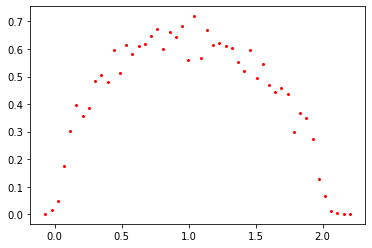

In [185]:

num_bins=50

n, bin_edges = np.histogram(v1b, bins=num_bins)
bins_center= (bin_edges[0:num_bins]+ bin_edges[1:])/2
n= n/np.sum(n)/(bin_edges[1]-bin_edges[0])

plt.figure()
plt.plot(bins_center,n,'o',color='red',markersize=2)#,color='C%d' % (i_n),label='Na=%d' % (i_n+1) )
# plt.xlim([-0.01,0.03])
# plt.ylim([0,20])

# n, bin_edges = np.histogram(v2b, bins=num_bins)
# bins_center= (bin_edges[0:num_bins]+ bin_edges[1:])/2
# n= n/np.sum(n)/(bin_edges[1]-bin_edges[0])
# plt.plot(bins_center,n,'o',color='blue',markersize=2)#,color='C%d' % (i_n),label='Na=%d' % (i_n+1) )

plt.show()


# log negativity

In [4]:

def ising_chain_partial(La,L, g=1.0, h=0.0, cyclic=True,
                sparse=True):

# g=0
# h=0
# cyclic=True
# m= 4
    dims = [r] * L  # shape (n, m)

    # generate tuple of all site coordinates
    # sites = tuple(itertools.product(range(n)))
    sites= tuple(range(La))
    # print(sites)

    # generate neighbouring pairs of coordinates
    def gen_pairs():
        for i in sites:
    #         print(i)
            right = (i + 1) % L 
            # ignore wraparound coordinates if not cyclic
            if cyclic or right != 0:
                yield (i, right)

    # generate all pairs of coordinates and directions
    pairs_ss = tuple(gen_pairs())
    # pairs_ss = tuple(itertools.product(gen_pairs(), 'xyz'))
    print(pairs_ss)
#     print(sites)

    # make XX, YY and ZZ interaction from pair_s
    #     e.g. arg ([(3, 4), (3, 5)], 'z')
    def interactions(pair):
        Sz = spin_operator('z', sparse=True)
        return -ikron([2*Sz, 2*Sz], dims, inds=pair)

    # function to make Z field at ``site``
    def fields(site):
        Sx = spin_operator('x', sparse=True)
        Sz = spin_operator('z', sparse=True)
        return -ikron(g * 2*Sx+ h * 2*Sz, dims, inds=[site])

    # combine all terms
    all_terms = itertools.chain(map(interactions, pairs_ss),
                                map(fields, sites))
    H = sum(all_terms)

    # can improve speed of e.g. eigensolving if known to be real
    if isreal(H):
        H = H.real

    if not sparse:
        H = qarray(H.A)
    else:
        H= quimb.core.sparse_matrix(H)

    return H


In [278]:
La = 4
Lb = 4
Lab = La + Lb
Lc = 12
Nrep = 100

r = 2
Nab = r**Lab
Nc = r**Lc
dims = [r] * (Lab+Lc)

H1ref = ising_chain(L=Lab, g=1.05, h=-0.5, cyclic=False,sparse=False)

ge0={"4":6.16103425,"6":9.60646994,"8":13.0528867, "10":16.499332, "12":19.94577803, "14":23.392224094, "16":26.83867014, "18":30.28511620}
H1 = ising_chain(L=Lab, g=1.05, h=-0.5, cyclic=False,sparse=True)

# beta_sw = np.arange(0.0,1.01,0.1)
beta_sw = np.linspace(0,4,20)
Nbeta = 100

ln1 = np.zeros((len(beta_sw),Nrep))
ln_ref3 = np.zeros((len(beta_sw),Nrep))

for i_beta in range(len(beta_sw)):
    beta = beta_sw[i_beta]/(ge0["%d" % (Lab)]/Lab)

    t = time.time()
    ebH = scipy.linalg.expm(-beta*H1ref/2)
#     print("exp: ", time.time()- t)

    for i_r in range(Nrep):
        #### no symmetry
        X=np.random.randn(Nab,Nc)+1j*np.random.randn(Nab,Nc)

        t = time.time()
        Xref= np.dot(ebH,X)
        mat= dot(Xref,np.matrix(Xref).H)
        rho= mat / np.trace(mat)
        ln_ref3[i_beta,i_r] = logneg(rho, dims=[r]*Lab, sysa=np.arange(La))
#         print( time.time()- t)

#         t = time.time()
#         if beta >0:
#             for i_b in range(Nbeta):
#                 X -= (beta/Nbeta/2)*dot(H1,X)
#         psi = normalize(np.reshape(X,[Nab*Nc,1]))
#         ln1[i_beta,i_r]=logneg_subsys(psi, dims=dims, sysa=np.arange(La), sysb=np.arange(La,Lab))
#         print("approx: ", time.time()- t)


((0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7))
((0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7))


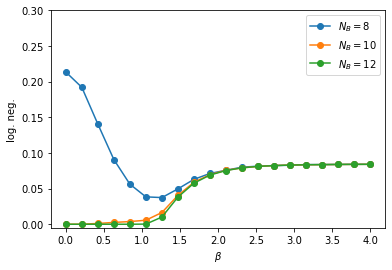

In [279]:
plt.figure()
# plt.plot(beta_sw,np.mean(ln1,axis=1),"o-")
plt.plot(beta_sw,np.mean(ln_ref,axis=1),"o-",label=r"$N_B = 8$")
plt.plot(beta_sw,np.mean(ln_ref2,axis=1),"o-",label=r"$N_B = 10$")
plt.plot(beta_sw,np.mean(ln_ref3,axis=1),"o-",label=r"$N_B = 12$")
# plt.plot(beta_sw,logneg,"x")
plt.ylim([-0.005,0.3])
plt.legend()
plt.xlabel(r"$\beta$")
plt.ylabel("log. neg.")
plt.show()

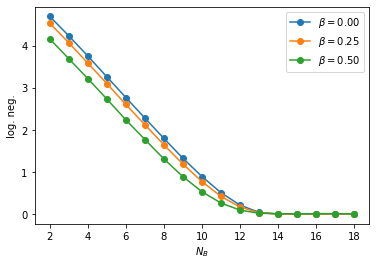

In [218]:
La = 6
Lb = La
Lab = La + Lb
Lc_sw = np.arange(2,19)

beta_list = [0,1/4,1/2]


plt.figure()

for i_beta in range(len(beta_list)):
    beta0 = beta_list[i_beta]
    Lcs=[]
    ln_avg=[]
    for i_c in range(len(Lc_sw)):
        Lc = Lc_sw[i_c]
        f1= 'TPS_b_%.2f_Labc_%d_%d_%d.npz' % (beta0,La,Lb,Lc)
        data_dir = 'thermal_data/' 
        fname = data_dir+f1
        if path.exists(fname):
            npzfile = np.load(fname)
            logneg_vals=npzfile['logneg']
            ln_avg.append(np.mean(logneg_vals))
            Lcs.append(Lc)
#             print('Averaged over %d states' % (len(logneg)))

    plt.plot(Lcs,ln_avg,"o-",label=r"$\beta = %.2f $" % (beta0))

plt.xlabel(r"$N_B$")
plt.ylabel("log. neg.")
plt.legend()

plt.show()

# benchmark log neg efficient

In [ ]:
La = 8
Lb = La
Lab = La + Lb
Lc_sw = np.arange(3)
Nrep = 1

r = 2
Nab = r**Lab
dims = [r] * Lab

ge0={"8":13.0528867, "10":16.499332, "12":19.94577803, "14":23.392224094, "16":26.83867014, "18":30.28511620}
beta0=1/4
beta = beta0/(ge0["%d" % (Lab)]/Lab)
Nbeta = 6

if beta>0:
    H1 = ising_chain(L=Lab, g=1.05, h=-0.5, cyclic=False,sparse=True)

logneg_vals = np.zeros((len(Lc_sw),Nrep))
logneg_vals_2 = np.zeros((len(Lc_sw),Nrep))

for i_c in range(len(Lc_sw)):
    Lc = Lc_sw[i_c]    
    Nc = r**Lc

   
    for i_r in range(Nrep):
        if i_r%10 ==0:
            print("(Labc, r): ", La, Lb, Lc, i_r)
        #### no symmetry

        X=np.random.randn(Nab,Nc)+1j*np.random.randn(Nab,Nc)

        if beta >0:
            for i_b in range(Nbeta):
                X -= (beta/Nbeta/2)*dot(H1,X)
        
#         t_timer=time.time()
#         mat= dot(X,np.matrix(X).H)
#         rho= mat / np.trace(mat)
#         logneg_vals[i_c,i_r]=logneg(np.matrix(rho), dims=dims, sysa=np.arange(La))
#         elapsed = time.time() - t_timer
#         print("matrix elapsed time = %.2f " % (elapsed)+ "sec")        
        
        t_timer=time.time()
        psi = np.reshape(X,[Nab*Nc,1])
        logneg_vals_2[i_c,i_r]=logneg_subsys_approx(normalize(psi), dims=[r]*(Lab+Lc), sysa=np.arange(La), sysb=np.arange(La,Lab))
        elapsed = time.time() - t_timer
        print("vector elapsed time = %.2f " % (elapsed)+ "sec")        

        

((0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15))


# Renyi negativity

In [166]:
from quimb.linalg.approx_spectral import *

La = 4
Lb = La
Lab = La + Lb
Lc_sw = np.arange(2,9)
Nrep = 100
α = 10 # Renyi index

r = 2
Nab = r**Lab
dims = [r] * Lab

ge0={"4":6.16103425,"6":9.60646994,"8":13.0528867, "10":16.499332, "12":19.94577803, "14":23.392224094, "16":26.83867014, "18":30.28511620}
beta0=1/2
beta = beta0/(ge0["%d" % (Lab)]/Lab)
Nbeta = 6

if beta>0:
    H1 = ising_chain(L=Lab, g=1.05, h=-0.5, cyclic=False,sparse=True)

logneg_vals = np.zeros((len(Lc_sw),Nrep))
logneg_vals_2 = np.zeros((len(Lc_sw),Nrep))
R3 = np.zeros((len(Lc_sw),Nrep))
R3_o = np.zeros((len(Lc_sw),Nrep))

for i_c in range(len(Lc_sw)):
    Lc = Lc_sw[i_c]    
    Nc = r**Lc

   
    for i_r in range(Nrep):
        if i_r%10 ==0:
            print("(Labc, r): ", La, Lb, Lc, i_r)
        #### no symmetry

        X=np.random.randn(Nab,Nc)+1j*np.random.randn(Nab,Nc)

        if beta >0:
            for i_b in range(Nbeta):
                X -= (beta/Nbeta/2)*dot(H1,X)
        
        t_timer=time.time()
        psi = normalize(np.reshape(X,[Nab*Nc,1]))
#         logneg_vals[i_c,i_r]=logneg_subsys_approx(normalize(psi), dims=[r]*(Lab+Lc), sysa=np.arange(La), sysb=np.arange(La,Lab))
# #         elapsed = time.time() - t_timer
# #         print("vector elapsed time = %.2f " % (elapsed)+ "sec")        

        rho = lazy_ptr_linop(psi, dims=[r]*(Lab+Lc), sysa=np.arange(Lab))
        rT = lazy_ptr_ppt_linop(psi, dims=[r]*(Lab+Lc), sysa=np.arange(La), sysb=np.arange(La,Lab))
#         logneg_vals_2[i_c,i_r] = log2(approx_spectral_function(rT, f=abs))
#         R3[i_c,i_r] = log(approx_spectral_function(rT, lambda x: x**3)/approx_spectral_function(rho, lambda x: x**3))    
        R3[i_c,i_r] = approx_spectral_function(rT, lambda x: x**α)**(1/α)

        mat = np.dot(X,np.matrix(X).H)
        rho_o = mat/np.trace(mat)
        rT_o = partial_transpose(rho_o, dims=[r]*Lab, sysa=np.arange(La))
        R3_o[i_c,i_r] = np.real(np.trace(np.linalg.matrix_power(rT_o,α)))**(1/α)
                       

((0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7))
(Labc, r):  4 4 2 0
(Labc, r):  4 4 2 10
(Labc, r):  4 4 2 20
(Labc, r):  4 4 2 30
(Labc, r):  4 4 2 40
(Labc, r):  4 4 2 50
(Labc, r):  4 4 2 60
(Labc, r):  4 4 2 70
(Labc, r):  4 4 2 80
(Labc, r):  4 4 2 90
(Labc, r):  4 4 3 0
(Labc, r):  4 4 3 10
(Labc, r):  4 4 3 20
(Labc, r):  4 4 3 30
(Labc, r):  4 4 3 40
(Labc, r):  4 4 3 50
(Labc, r):  4 4 3 60
(Labc, r):  4 4 3 70
(Labc, r):  4 4 3 80
(Labc, r):  4 4 3 90
(Labc, r):  4 4 4 0
(Labc, r):  4 4 4 10
(Labc, r):  4 4 4 20
(Labc, r):  4 4 4 30
(Labc, r):  4 4 4 40
(Labc, r):  4 4 4 50
(Labc, r):  4 4 4 60
(Labc, r):  4 4 4 70
(Labc, r):  4 4 4 80
(Labc, r):  4 4 4 90
(Labc, r):  4 4 5 0
(Labc, r):  4 4 5 10
(Labc, r):  4 4 5 20
(Labc, r):  4 4 5 30
(Labc, r):  4 4 5 40
(Labc, r):  4 4 5 50
(Labc, r):  4 4 5 60
(Labc, r):  4 4 5 70
(Labc, r):  4 4 5 80
(Labc, r):  4 4 5 90
(Labc, r):  4 4 6 0
(Labc, r):  4 4 6 10
(Labc, r):  4 4 6 20
(Labc, r):  4 4 6 30
(Labc, r):  4 4 6 40
(La

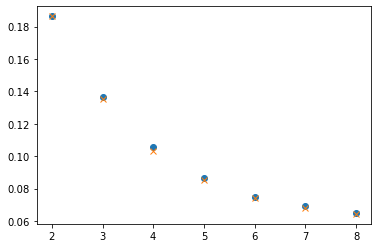

In [167]:
# plt.plot(Lc_sw,np.mean(logneg_vals,axis=1),"o")
# plt.plot(Lc_sw,np.mean(logneg_vals_2,axis=1),"x")
plt.plot(Lc_sw,np.mean(R3_o,axis=1),"o")
plt.plot(Lc_sw,np.mean(R3,axis=1),"x")


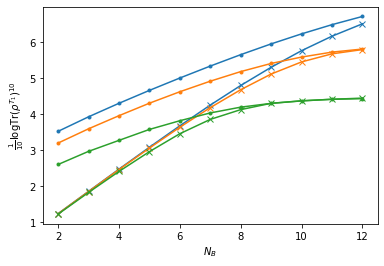

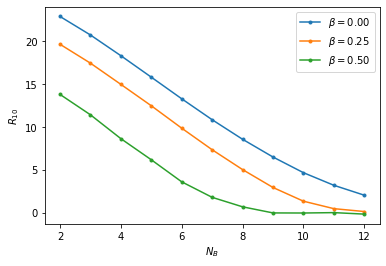

In [287]:
α = 10
La = 6
Lb = La
Lab = La + Lb
Lc_sw = np.arange(2,19)

beta_list = [0,1/4,1/2]



for i_beta in range(len(beta_list)):
    beta0 = beta_list[i_beta]
    Lcs=[]
    Rn_avg=[]
    RTn_avg=[]
    for i_c in range(len(Lc_sw)):
        Lc = Lc_sw[i_c]
        f1= 'R%d_b_%.2f_Labc_%d_%d_%d.npz' % (α,beta0,La,Lb,Lc)
        data_dir = 'thermal_data/' 
        fname = data_dir+f1
        if path.exists(fname):
            npzfile = np.load(fname)
            Rn_vals=npzfile['Rn']
            Rn_avg.append(np.mean(Rn_vals))
            RTn_vals=npzfile['RTn']
            RTn_avg.append(np.mean(RTn_vals))
            Lcs.append(Lc)
#             print('Averaged over %d states' % (len(logneg)))

    plt.figure(1)
    RTn = np.array(RTn_avg)/α
    Rn = np.array(Rn_avg)/α
    plt.plot(Lcs,RTn,".-",color="C%d" % (i_beta),label=r"$Neg, \beta = %.2f $" % (beta0))
    plt.plot(Lcs,Rn,"x-",color="C%d" % (i_beta),label=r"Renyi, $\beta = %.2f $" % (beta0))
    plt.figure(2)
    Rn = np.array(RTn_avg)-np.array(Rn_avg)
    plt.plot(Lcs,Rn,".-",label=r"$\beta = %.2f $" % (beta0))

plt.figure(1)
plt.xlabel(r"$N_B$")
plt.ylabel(r"$\frac{1}{%d}\log {\rm Tr}(\rho^{T_1})^{%d}$" % (α,α))
# plt.legend()

plt.figure(2)
plt.xlabel(r"$N_B$")
plt.ylabel(r"$R_{%d}$" % (α))
plt.legend()

plt.show()